## Packages and Data

Read in and clean the 'Housing Price Gap' Data

In [60]:
import pandas as pd # Needed for reading csv
import numpy as np # Needed for setting : to nan
import matplotlib.pyplot as plt # For graphing
import seaborn as sns # For fancy plots

In [167]:
raw_ratio = pd.read_csv('Data/House_Price_Wages_Ratio.csv', # Read in the csv for the ratio data
                        encoding = 'utf-8')
raw_ratio.columns

Index(['New Code', 'Old Code', 'Area', '2002', '2003', '2004', '2005', '2006',
       '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015',
       '2016', '2017', '2018', '2019', '2020'],
      dtype='object')

In [168]:
# Desired columns only
# Keep the "Old Code" becuase the tourism spend data doesn't have the new code
# This will allow a separate join on this column to work for this dataset
ratio = raw_ratio[['New Code','Old Code','Area','2019']].dropna().rename(columns={
    'New Code': 'Area_Code',
    'Old Code': 'Old_Code',
    '2019': 'r2019'})
ratio.head()

,Area_Code,Old_Code,Area,r2019
1,E09000001,00AA,City of London,:
2,E09000002,00AB,Barking and Dagenham,10.75
3,E09000003,00AC,Barnet,14.19
4,E09000004,00AD,Bexley,9.61
5,E09000005,00AE,Brent,15.59


In [169]:
# Get rid of 'City of London' value, which has an NaN stored as ':'
ratio = ratio.drop(ratio[ratio.r2019 == ':'].index)
ratio.head()

,Area_Code,Old_Code,Area,r2019
2,E09000002,00AB,Barking and Dagenham,10.75
3,E09000003,00AC,Barnet,14.19
4,E09000004,00AD,Bexley,9.61
5,E09000005,00AE,Brent,15.59
6,E09000006,00AF,Bromley,10.73


In [170]:
# Convert the column to floats, so that it can be plotted
ratio['r2019'] = pd.to_numeric(ratio['r2019'])
ratio.dtypes

Area_Code     object
Old_Code      object
Area          object
r2019        float64
dtype: object

In [149]:
# Creates basic stats for any given set of input values
# Provide the data, the title, and the label for the y-axis on the boxplot
def summary_stats(data_col, title, label):
    print(f'\nSummary Statistics for:\n\n{title}\n\n{data_col.describe()}\n') # Summary statistics
    print('Box Plot:\n')
        # Boxplot
    plt.figure(figsize=(2,5)) 
    plt.boxplot(data_col, widths = 0.5)
    plt.ylabel(label, size=12)
    plt.xticks([]) # So no ticks appear on x axis
    plt.title(title)
    plt.show()


Summary Statistics for:

House Price to
Earnings Ratio

count    42.000000
mean     12.456667
std       4.159593
min       5.210000
25%      10.482500
50%      12.685000
75%      14.362500
max      27.640000
Name: r2019, dtype: float64

Box Plot:



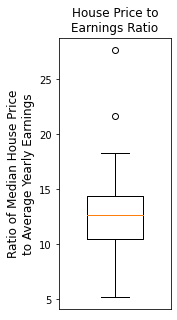

In [151]:
summary_stats(ratio.r2019,
              'House Price to\nEarnings Ratio',
              'Ratio of Median House Price\nto Average Yearly Earnings')

In [121]:
raw_rental = pd.read_excel('Data/Rental_Rates.xls', # Read in the excel sheet
                           sheet_name = 'Table2.7')
# There's loads of junk at the top, with the column headings I want on row five
# I save the row I want as a variable to assign as the index labels later
header_row = raw_rental.iloc[5]

In [153]:
# Drop the first five rows, including the row we want as the index labels, so its not repeated
rental_cleaned = raw_rental.drop(list(range(6)))
rental_cleaned.columns = header_row # Assign the row from before as index labels
rental_cleaned.head()

5,NaN,LA Code1,Area Code1,Area,Count of rents,Mean,Lower quartile,Median,Upper quartile
6,NaN,NaN,E92000001,ENGLAND,480750,898,585,755,1050
7,NaN,NaN,E12000001,NORTH EAST,23690,572,425,500,625
8,NaN,1355,E06000047,County Durham UA,5650,516,400,475,550
9,NaN,1350,E06000005,Darlington UA,2300,501,400,450,550
10,NaN,724,E06000001,Hartlepool UA,800,494,415,495,550


In [129]:
# Pick out the desired columns and relabel them
# I must make sure all dataframes have the area codes stored under "Area_Code" for merging
rental_data = rental_cleaned[['Area Code1','Count of rents','Mean']].rename(columns={
    'Area Code1': 'Area_Code',
    'Count of rents':'Rent_Count',
    'Mean':'Rent_Price_Mean'})
rental_data.head()

# NOTE: This dataset includes all other administrative areas in the UK as well

5,Area_Code,Rent_Count,Rent_Price_Mean
6,E92000001,480750,898
7,E12000001,23690,572
8,E06000047,5650,516
9,E06000005,2300,501
10,E06000001,800,494


In [130]:
raw_open_space = pd.read_csv('Data/Open_Space.csv', # Read in the csv
                        encoding = 'utf-8')
raw_open_space.columns

Index(['Ward_GSS_CODE', 'Ward_NAME', 'BOROUGH_LB_GSS_CD', 'BOROUGH_Name',
       'Total area of ward (sq m)', 'All Open Space', '% open space',
       'Open Space with access', '% Open Space with access',
       '% of open space that has access'],
      dtype='object')

In [138]:
# Select desired columns and rename, keeping Area_Code consistent
open_space = raw_open_space[['Ward_GSS_CODE',
                             'Total area of ward (sq m)',
                             '% open space']].rename(columns={
    'Ward_GSS_CODE':'Area_Code',
    'Total area of ward (sq m)': 'Land_Area(m^2)',
    '% open space':'%Open_Space_2013'})

In [139]:
open_space.head()

# NOTE: All the wards are in the dataframe as well, with the boroughs at the bottom
# The area code will serve as a unique identify for the boroughs and filter out the wards

,Area_Code,Land_Area(m^2),%Open_Space_2013
0,E05000026,"1,282,926",21.9
1,E05000027,"1,364,442",20.6
2,E05000028,"1,288,085",1.9
3,E05000029,"3,384,193",56.0
4,E05000030,"3,450,576",50.4


In [162]:
raw_tourism_spend = pd.read_csv('Data/Tourism_Spend_2009.csv', # Read in the csv
                        encoding = 'utf-8')
raw_tourism_spend.columns

Index(['Code', 'Area', 'Overseas visitors (£ millions)',
       'Domestic visitors (£ millions)', 'Day visitors (£ millions)'],
      dtype='object')

In [163]:
# I need to sum the two values fir international and domestic spend together first
raw_tourism_spend.dtypes

Code                              object
Area                              object
Overseas visitors (£ millions)    object
Domestic visitors (£ millions)    object
Day visitors (£ millions)         object
dtype: object

In [164]:
tourism_spend_processed = raw_tourism_spend
tourism_spend_processed['Overseas visitors (£ millions)'] = tourism_spend_processed['Overseas visitors (£ millions)'].str.replace(',','').astype('float')
tourism_spend_processed['Domestic visitors (£ millions)'] = tourism_spend_processed['Domestic visitors (£ millions)'].str.replace(',','').astype('float')

Code                               object
Area                               object
Overseas visitors (£ millions)    float64
Domestic visitors (£ millions)    float64
Day visitors (£ millions)          object
dtype: object

In [165]:
tourism_spend_processed['Visitor_Spend(£m)'] = sum(tourism_spend_processed['Overseas visitors (£ millions)'],
                                                   tourism_spend_processed['Domestic visitors (£ millions)'])
tourism_spend_processed.dtypes

Code                               object
Area                               object
Overseas visitors (£ millions)    float64
Domestic visitors (£ millions)    float64
Day visitors (£ millions)          object
Visitor_Spend(£m)                 float64
dtype: object

In [166]:
# Note, this has the old area codes
tourism_spend_2009 = raw_tourism_spend[['Code',
                             'Visitor_Spend(£m)']].rename(columns={
    'Code':'Old_Code'})

In [ ]:
# Now I'm ready to start joining the data
y_with_tourism = 